In [115]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import time

import tsai.all as ts
import torch
from torch import nn

from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_multilabel_classification
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from my_utilities import time_frequency_analysis, mma_Partition

In [17]:
def cross_validation(x, y, cv_number = 20, test_size = 0.1):
    acc = []
    batch_tfms = [ts.TSStandardize(by_sample=True)]
    tfms  = [None, [ts.Categorize()]]
    cfm = np.zeros([4,4])
    for _ in np.arange(cv_number):
        x, y = shuffle(x, y)
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size)
            
        ear_X, ear_y, splits = ts.combine_split_data([X_train, X_test], [y_train, y_test])
        dls = ts.get_ts_dls(ear_X, ear_y, 
                         splits=splits, 
                         tfms=tfms, drop_last=False, 
                         shuffle_train=False, batch_tfms=batch_tfms, bs=10_000)        
        model = ts.build_ts_model(ts.ROCKET, dls=dls)
        
        X_train, y_train = ts.create_rocket_features(dls.train, model)
        X_valid, y_valid = ts.create_rocket_features(dls.valid, model)
        X_train.shape, X_valid.shape
    
        ridge = RidgeClassifierCV(alphas=np.logspace(-8, 8, 17), normalize=True)
        ridge.fit(X_train, y_train)
        print(f'alpha: {ridge.alpha_:.2E}  train: {ridge.score(X_train, y_train):.5f}  valid: {ridge.score(X_valid, y_valid):.5f}')
        acc.append(ridge.score(X_valid, y_valid))
        roc = roc_auc_score(y_valid, ridge.decision_function(X_valid), average=None)
        cfm += confusion_matrix(y_valid, ridge.predict(X_valid))
        print(cfm)
    return acc, cfm, roc

In [ ]:
srate = 2000
new_srate = 200
ele_original = pd.read_csv('data/ele_4_60_hz.csv', header = None, index_col = None).to_numpy()
# shape = (4, 15, 2, 20000, 14)

mask = np.unique(np.array(list(range(5,59,5))+
                          list(range(7,59,7))+
                          list(range(9,59,9))+
                          list(range(11,59,11))))-2

data = []
total_acc = []
for time_in_sec in [1]:
    sec = time_in_sec # time step length
    if 9%time_in_sec ==0:
        ele = np.reshape(
            ele_original, (20000,15,4,2,14), order = 'F').\
                transpose([2,1,3,0,4])[:,:,:,srate::srate//new_srate,:]
    else:
        ele = np.reshape(
            ele_original, (20000,15,4,2,14), order = 'F').\
                transpose([2,1,3,0,4])[:,:,:,srate:-srate:srate//new_srate,:]
        
    ear_ele = ele[...,:8].astype(np.float32).reshape(-1,int(200 * sec),8).transpose([0,2,1])
    y = np.repeat([0,1,2,3], int(ear_ele.shape[0]/4))
    
    # z-score
    ear_ele = (ear_ele - ear_ele.mean(axis = 2)[...,np.newaxis])\
                    /ear_ele.std(axis = 2)[...,np.newaxis]

    
    # time frequency analysis for ear-EEG
    temp_ear_ele = []
    for flame in ear_ele:
        _,_,temp = time_frequency_analysis(
            flame.T, srate = new_srate, max_freq = 60, 
            min_freq = 2, num_freq = 59, fwhm = 0.75 * time_in_sec)
        # _,_,temp = time_frequency_analysis_output_1s(
        #     i.T, srate = new_srate, max_freq = 60, min_freq = 2, num_freq = 59, fwhm = 1)    
        temp_ear_ele.append(temp)
        
    ear_ele = np.asarray(temp_ear_ele)
    
    # temp_acc, cf_matrix, roc = cross_validation(ear_ele, y, cv_number = 1, test_size = 0.2)
    # total_acc.append(temp_acc)

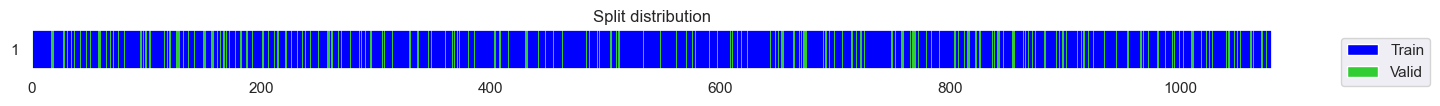

alpha: 1.00E+01  train: 0.92824  valid: 0.54167


In [93]:
batch_tfms = [ts.TSStandardize(by_sample=True)]
tfms  = [None, [ts.Categorize()]]

x, y = shuffle(ear_ele, y)
splits = ts.get_splits(y, valid_size = 0.2, stratify=True, random_state=23, shuffle=True)

dls = ts.get_ts_dls(x, y, 
                 splits=splits, 
                 tfms=tfms, drop_last=False, 
                 shuffle_train=False, batch_tfms=batch_tfms, bs=10_000)        
model = ts.build_ts_model(ts.ROCKET, dls=dls)
X_train, y_train = ts.create_rocket_features(dls.train, model)
X_valid, y_valid = ts.create_rocket_features(dls.valid, model)
ridge = RidgeClassifierCV(alphas=np.logspace(-8, 8, 17), normalize=True)
ridge.fit(X_train, y_train)

print(f'alpha: {ridge.alpha_:.2E}  train: {ridge.score(X_train, y_train):.5f}  valid: {ridge.score(X_valid, y_valid):.5f}')

In [129]:
ridge.predict_proba

AttributeError: 'RidgeClassifierCV' object has no attribute 'predict_proba'

In [65]:
# roc_auc_score(a00.toarray().astype(np.int32), 
#               ridge.decision_function(X_valid), 
#               average=None, multi_class = 'ovr')

array([0.89814815, 0.91203704, 0.96527778, 0.94675926])

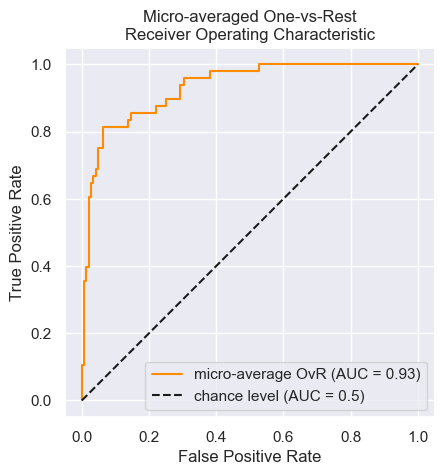

In [107]:
# enc = OneHotEncoder()
# a00 = enc.fit_transform(y_valid.reshape(-1, 1))

# RocCurveDisplay.from_predictions(
#     a00.toarray().astype(np.int32).ravel(),
#     ridge.decision_function(X_valid).ravel(),
#     name="micro-average OvR",
#     color="darkorange",
# )
# plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
# plt.axis("square")
# plt.xlabel("False Positive Rate")
# plt.ylabel("True Positive Rate")
# plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
# plt.legend()
# plt.show()



enc = OneHotEncoder()
a00 = enc.fit_transform(y_valid.reshape(-1, 1))

RocCurveDisplay.from_predictions(
    roc_curve_4s['y_true'],
    roc_curve_4s['y_pred'],
    name="micro-average OvR",
    color="darkorange"
)



plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

In [117]:
# roc_curve_4s = pd.DataFrame({'y_pred': ridge.decision_function(X_valid).ravel(),
#                              'y_true': a00.toarray().astype(np.int32).ravel()}).assign(time = '4s')

# roc_curve_3s = pd.DataFrame({'y_pred': ridge.decision_function(X_valid).ravel(),
#                              'y_true': a00.toarray().astype(np.int32).ravel()}).assign(time = '3s')

# roc_curve_2s = pd.DataFrame({'y_pred': ridge.decision_function(X_valid).ravel(),
#                              'y_true': a00.toarray().astype(np.int32).ravel()}).assign(time = '2s')

# roc_curve_1s = pd.DataFrame({'y_pred': ridge.decision_function(X_valid).ravel(),
#                              'y_true': a00.toarray().astype(np.int32).ravel()}).assign(time = '1s')

cdf = pd.concat([roc_curve_1s, roc_curve_2s, roc_curve_3s, roc_curve_4s])  # .to_csv(r'fin_result_roc.csv', index = None)

In [150]:
fpr, tpr, thresholds = roc_curve(roc_curve_4s['y_true'], roc_curve_4s['y_pred'], pos_label=1)

<function matplotlib.pyplot.show(close=None, block=None)>

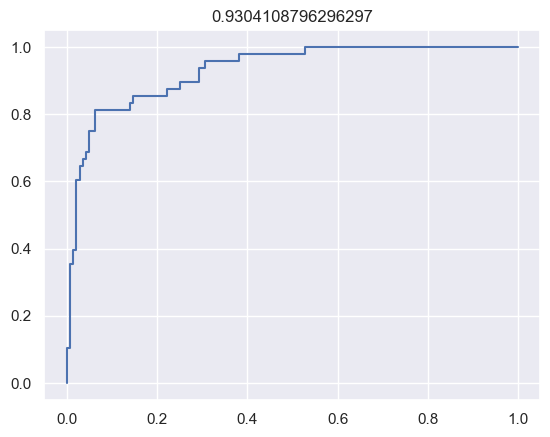

In [151]:
plt.figure()
# plt.scatter(fpr, tpr)
plt.plot(fpr, tpr)
plt.title(roc_auc_score(roc_curve_4s['y_true'], roc_curve_4s['y_pred']))
plt.show

In [177]:
# fpr, tpr, thresholds = roc_curve(roc_curve_4s['y_true'], roc_curve_4s['y_pred'], pos_label=1)

total_fpr = []
total_tpr = []
total_auc = []

ruc_df = pd.DataFrame()
for sec in ['1s', '2s', '3s', '4s']:  # , 
    temp_df = pd.DataFrame()
    fpr, tpr, _ = roc_curve(cdf[cdf['time'] == sec]['y_true'], 
                            cdf[cdf['time'] == sec]['y_pred'], pos_label=1)
    auc = roc_auc_score(cdf[cdf['time'] == sec]['y_true'], 
                  cdf[cdf['time'] == sec]['y_pred'])
    
    temp_df[f'fpr'] = fpr
    temp_df[f'tpr'] = tpr
    temp_df = temp_df.assign(AUC = auc)
    
    ruc_df = pd.concat([ruc_df, temp_df]).reset_index(drop=True)
# total_fpr = np.asarray(total_fpr)
# total_tpr = np.asarray(total_tpr)
# total_auc = np.asarray(total_fpr)

In [178]:
ruc_df
# temp_df.assign(AUC = auc)

,fpr,tpr,AUC
0,0.000000,0.000000,0.756130
1,0.000000,0.004630,0.756130
2,0.000000,0.018519,0.756130
3,0.001543,0.018519,0.756130
4,0.001543,0.041667,0.756130
...,...,...,...
509,0.381944,0.958333,0.930411
510,0.381944,0.979167,0.930411
511,0.527778,0.979167,0.930411
512,0.527778,1.000000,0.930411


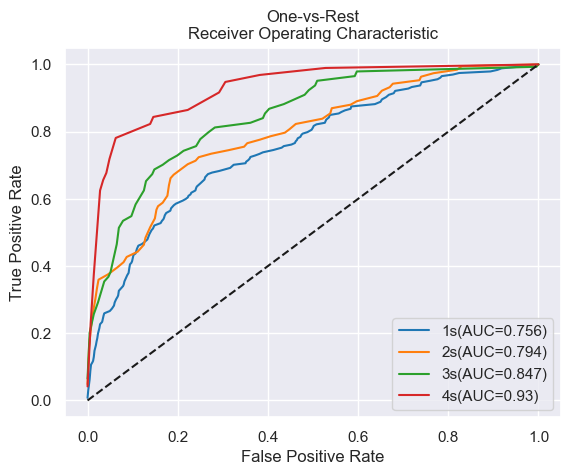

In [204]:
# tips = sns.load_dataset('tips')
sns.lineplot(data = ruc_df, x = 'fpr', y = 'tpr', hue = 'AUC', ci=None, palette="tab10")
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.legend([f"1s(AUC={np.unique(ruc_df['AUC'].to_numpy().round(3))[0]})",
            f"2s(AUC={np.unique(ruc_df['AUC'].to_numpy().round(3))[1]})",
            f"3s(AUC={np.unique(ruc_df['AUC'].to_numpy().round(3))[2]})",
            f"4s(AUC={np.unique(ruc_df['AUC'].to_numpy().round(3))[3]})",
            ])

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest\nReceiver Operating Characteristic")
plt.savefig('ROCKET_ROC.png', dpi=300, bbox_inches='tight')
plt.show()

In [189]:
np.unique(ruc_df['AUC'].to_numpy())[0]

0.7561299725651578